In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import string
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.simplefilter('ignore')
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.utils import resample

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/NEWS_DATASET/Tweets_Synthetic_data.csv')

In [ ]:
df.head()

,text,category
0,Pakistan needs Imran Khan as prime minister Pa...,True
1,Someone tell this dimwit that Nawaz Sharif ran...,False
2,Chairman Bilawal Bhutto Zardari inaugurated th...,False
3,This guy already has blood on his hands over t...,False
4,The zealous ppl of Punjab will put an end to t...,True


In [ ]:
df['category'].value_counts()

True     2645
False    2355
Name: category, dtype: int64

AS the data is highly imbalanced so 1st balance the data

In [ ]:
# # Separate the majority and minority classes
# majority_class = df[df['category'] == 'True']
# minority_class = df[df['category'] == 'Fake']

# # Undersample the majority class to match the number of samples in the minority class
# majority_undersampled = resample(majority_class,
#                                  replace=False,
#                                  n_samples=len(minority_class),
#                                  random_state=42)

# # Combine the undersampled majority class with the original minority class
# balanced_df = pd.concat([majority_undersampled, minority_class])

# # Shuffle the rows of the balanced dataset
# balanced_df = balanced_df.sample(frac=1, random_state=42)

# # Check the class distribution in the balanced dataset
# print(balanced_df['category'].value_counts())
# print("Now Data is balanced")

In [ ]:
df.shape

(5000, 2)

In [ ]:
df = df[['text', 'category']]
df.head(5)

,text,category
0,Pakistan needs Imran Khan as prime minister Pa...,True
1,Someone tell this dimwit that Nawaz Sharif ran...,False
2,Chairman Bilawal Bhutto Zardari inaugurated th...,False
3,This guy already has blood on his hands over t...,False
4,The zealous ppl of Punjab will put an end to t...,True


In [ ]:
df['category'].value_counts()

True     2645
False    2355
Name: category, dtype: int64

In [ ]:
print(df.isnull().sum(), "\n==================")
df = df.dropna(subset=['text'])
print(df.isnull().sum())

text        0
category    0
dtype: int64 
text        0
category    0
dtype: int64


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df['text'] = df['text'].str.replace('[^\w\s]', '')  # getting rid of special characters
df['text'] = df['text'].str.replace('\d+', '')  # removing numeric values from between the words
df['text'] = df['text'].apply(
    lambda x: x.translate(string.digits))  # removing numerical numbers
df['text'] = df['text'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))  # lower case conversion
stop = stopwords.words('english')
df['text'] = df['text'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))  # removing stop words
stemmer = WordNetLemmatizer()
df['text'] = [stemmer.lemmatize(word) for word in df['text']]  # converting words to their dictionary form

In [ ]:
# Encode the labels as integers
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'].values)

X = df['text']
y = df['category']



# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

In [ ]:
def encode_label(data, labels, batch_size=64):
    input_ids = []
    attention_masks = []
    
    # Convert the preprocessed data to BERT format
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    MAX_LEN = 100 # Maximum sequence length 

    for sentence in data:
        encoded_dict = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True,     # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,          # Pad or truncate all sentences.
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,  # Construct attn. masks.
                        return_tensors = 'pt',         # Return tensorflow tensors.
                   )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels.values)
    
    dataset = TensorDataset(input_ids, attention_masks, labels)
    dataloader = DataLoader(
            dataset,
            sampler = RandomSampler(dataset),
            batch_size = batch_size
        )

    return dataloader

train_dataloader = encode_label(X_train, y_train)
test_dataloader = encode_label(X_test, y_test)
val_dataloader = encode_label(X_test, y_test)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Set the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr = 0.0001, eps = 1e-8)
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Train the model
model.to(device)

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []


for epoch in range(epochs):
    # Set the model to training mode
    model.train()
    
    train_loss = 0
    val_loss = 0
    train_correct = 0
    val_correct = 0
    train_total = 0
    val_total = 0
    
    for step, batch in tqdm(enumerate(train_dataloader)):
        # Load the input data and labels
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)
        
        # Clear any previously calculated gradients
        model.zero_grad()

        # Perform a forward pass
        outputs = model(batch_input_ids, 
                             token_type_ids=None, 
                             attention_mask=batch_attention_masks, 
                             labels=batch_labels)

        loss, logits = outputs[0], outputs[1]
        
        # Accumulate the training loss
        train_loss += loss.item()
        
        # Get the predicted labels
        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()
        predicted_labels = np.argmax(logits, axis=1)
        
        # Calculate the validation accuracy
        train_total += len(label_ids)
        train_correct += (predicted_labels == label_ids).sum().item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update the parameters of the model
        optimizer.step()

        # Update the learning rate scheduler
        scheduler.step()
        del loss
        
    # Calculate the average loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_accuracy = train_correct / train_total 
    
    # Set the model to evaluation mode
    model.eval()

    for batch in tqdm(val_dataloader):
        # Load the input data and labels
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        # Disable gradient calculations
        with torch.no_grad():
            # Perform a forward pass
            outputs = model(batch_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=batch_attention_masks,
                                   labels=batch_labels)
        
        loss, logits = outputs[0], outputs[1]
        
        # Accumulate the validation loss
        val_loss += loss.item()

        # Get the predicted labels
        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()
        predicted_labels = np.argmax(logits, axis=1)

        # Calculate the validation accuracy
        val_total += len(label_ids)
        val_correct += (predicted_labels == label_ids).sum().item()

    # Calculate the average loss and accuracy for this epoch
    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_accuracy = val_correct / val_total
    
    # append the results of epoch
    train_accuracies.append(avg_train_accuracy)
    val_accuracies.append(avg_val_accuracy)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)


    # Print the loss and accuracy for this epoch
    print("Epoch: {}/{}".format(epoch+1, epochs))
    print("Training Loss: {:.4f}".format(avg_train_loss))
    print("Validation Loss: {:.4f}".format(avg_val_loss))
    print("Training Accuracy: {:.2f}%".format(avg_train_accuracy * 100))    
    print("Validation Accuracy: {:.2f}%".format(avg_val_accuracy * 100))

55it [00:51,  1.07it/s]
100%|██████████| 24/24 [00:07<00:00,  3.06it/s]


Epoch: 1/10
Training Loss: 0.4426
Validation Loss: 0.2321
Training Accuracy: 77.49%
Validation Accuracy: 93.33%


55it [00:52,  1.05it/s]
100%|██████████| 24/24 [00:07<00:00,  3.02it/s]


Epoch: 2/10
Training Loss: 0.1337
Validation Loss: 0.1195
Training Accuracy: 95.57%
Validation Accuracy: 96.47%


55it [00:51,  1.06it/s]
100%|██████████| 24/24 [00:08<00:00,  2.89it/s]


Epoch: 3/10
Training Loss: 0.0848
Validation Loss: 0.0957
Training Accuracy: 97.60%
Validation Accuracy: 96.80%


55it [00:51,  1.06it/s]
100%|██████████| 24/24 [00:08<00:00,  2.92it/s]


Epoch: 4/10
Training Loss: 0.0778
Validation Loss: 0.1226
Training Accuracy: 97.91%
Validation Accuracy: 96.93%


55it [00:52,  1.06it/s]
100%|██████████| 24/24 [00:08<00:00,  2.91it/s]


Epoch: 5/10
Training Loss: 0.0614
Validation Loss: 0.0893
Training Accuracy: 98.31%
Validation Accuracy: 97.40%


55it [00:52,  1.06it/s]
100%|██████████| 24/24 [00:08<00:00,  2.91it/s]


Epoch: 6/10
Training Loss: 0.0565
Validation Loss: 0.0884
Training Accuracy: 98.11%
Validation Accuracy: 97.33%


55it [00:52,  1.06it/s]
100%|██████████| 24/24 [00:08<00:00,  2.92it/s]


Epoch: 7/10
Training Loss: 0.0517
Validation Loss: 0.1051
Training Accuracy: 98.31%
Validation Accuracy: 97.73%


55it [00:51,  1.06it/s]
100%|██████████| 24/24 [00:08<00:00,  2.94it/s]


Epoch: 8/10
Training Loss: 0.0437
Validation Loss: 0.1130
Training Accuracy: 98.46%
Validation Accuracy: 97.47%


55it [00:51,  1.06it/s]
100%|██████████| 24/24 [00:08<00:00,  2.93it/s]


Epoch: 9/10
Training Loss: 0.0418
Validation Loss: 0.1074
Training Accuracy: 98.43%
Validation Accuracy: 97.53%


55it [00:51,  1.06it/s]
100%|██████████| 24/24 [00:08<00:00,  2.93it/s]

Epoch: 10/10
Training Loss: 0.0398
Validation Loss: 0.1093
Training Accuracy: 98.49%
Validation Accuracy: 97.53%


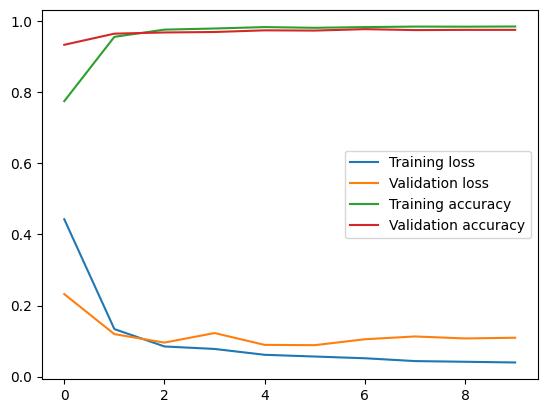

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')

# Plot the training and validation accuracies
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend()
plt.show()

In [ ]:
# Save the trained model
torch.save(model,'BERT.pt')

In [ ]:
def test(model, test_loader):
    model.eval()

    val_loss = 0
    val_correct = 0
    val_total = 0
    y_true = []
    y_pred = []
    for batch in tqdm(val_dataloader):
        # Load the input data and labels
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)
        
        # Perform a forward pass
        outputs = model(batch_input_ids, 
                               token_type_ids=None, 
                               attention_mask=batch_attention_masks,
                               labels=batch_labels)
        
        loss, logits = outputs[0], outputs[1]
        # Accumulate the validation loss
        val_loss += loss.item()

        # Compute the loss for this batch and add it to the total test loss
        val_loss += loss.item()

        # Get the predicted labels
        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()
        predicted_labels = np.argmax(logits, axis=1)

        # Calculate the validation accuracy
        val_total += len(label_ids)
        val_correct += (predicted_labels == label_ids).sum().item()
        
        # Append the ground truth and predicted labels for confusion matrix
        y_true.extend(label_ids.tolist())
        y_pred.extend(predicted_labels.tolist())

    # Compute the average test loss and accuracy for this epoch
    val_loss /= len(test_loader)
    accuracy = val_correct / val_total
    
    print(f' Test Accuracy: {accuracy} \n Test Loss {val_loss}')
    
    # Compute and print the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:')
    print(cm)
    
    return y_true, y_pred

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model from its saved state
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = ConvNet()
# model.to(device)
model = torch.load('/content/BERT.pt')
y_true, y_pred =test(model, val_dataloader)

100%|██████████| 24/24 [00:08<00:00,  2.96it/s]

 Test Accuracy: 0.9753333333333334 
 Test Loss 0.2187994635120655
Confusion Matrix:
[[687  21]
 [ 16 776]]


In [ ]:
from sklearn.metrics import classification_report

# calculate the classification report
print("Classification Reprot")
print(classification_report(y_true, y_pred))

Classification Reprot
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       708
           1       0.97      0.98      0.98       792

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



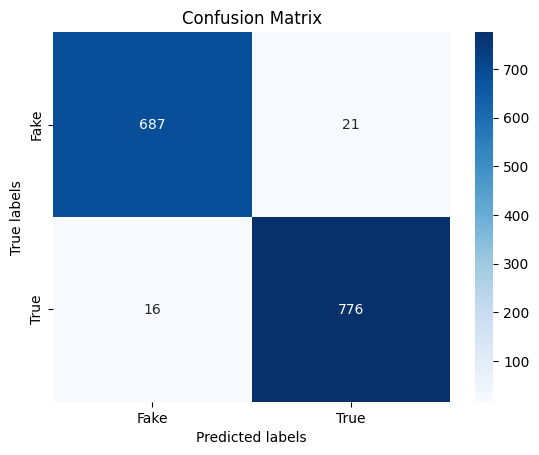

In [ ]:
# Compute and print the confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# Set the x-axis and y-axis labels
plt.xticks([0.5, 1.5], ['Fake', 'True'])
plt.yticks([0.5, 1.5], ['Fake', 'True'])

# Set the axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# To visualize the attenstions weights to each input tokens in the text each tweet

Attention Visualization: BERT uses attention mechanisms to focus on relevant words or tokens in the input sequence. You can visualize the attention weights to understand which parts of the input the model is paying attention to and how they contribute to the predictions.

Attention Weights - Index 0:
[0.9746095]


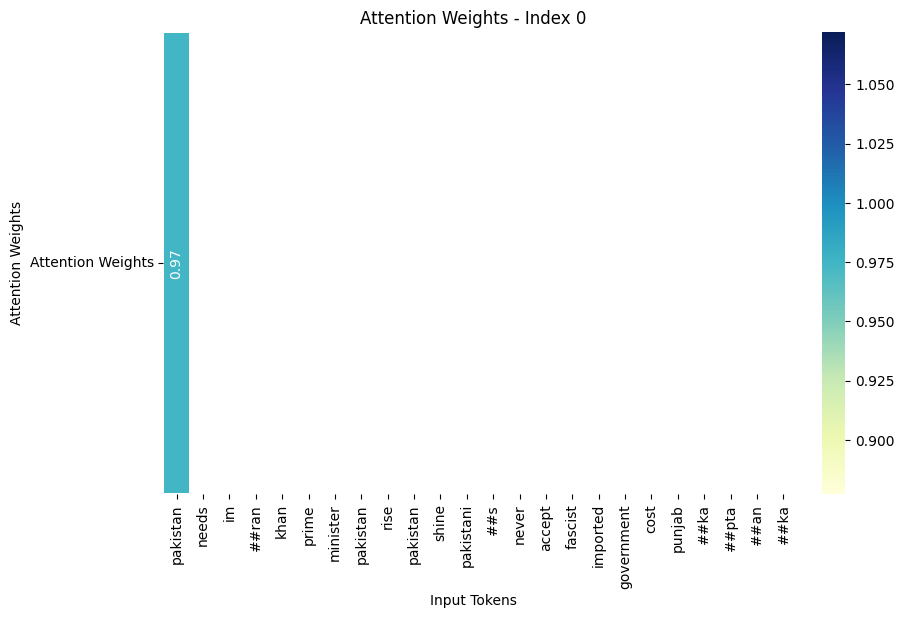

Attention Weights - Index 1:
[-3.8951538]


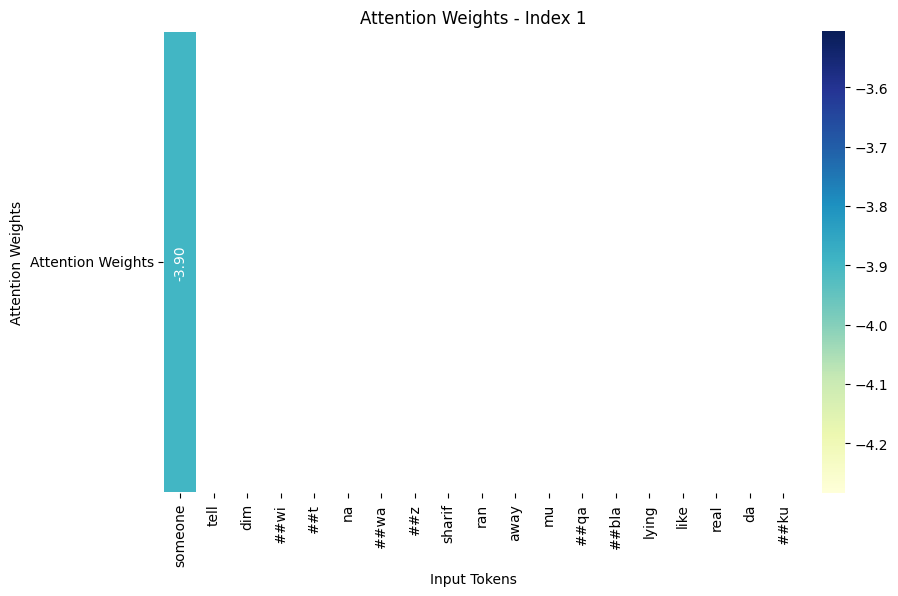

Attention Weights - Index 2:
[-3.8074536]


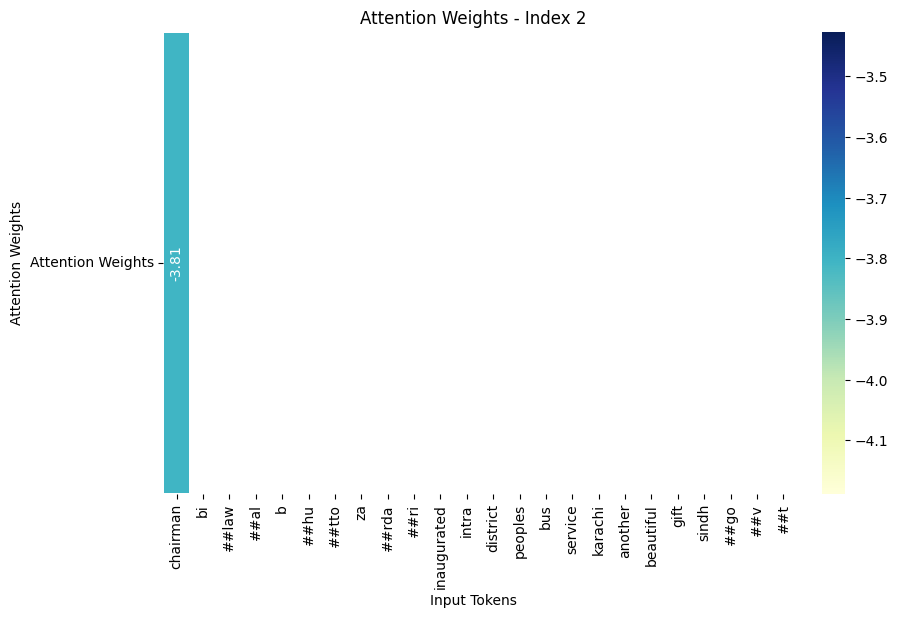

Attention Weights - Index 3:
[-3.851984]


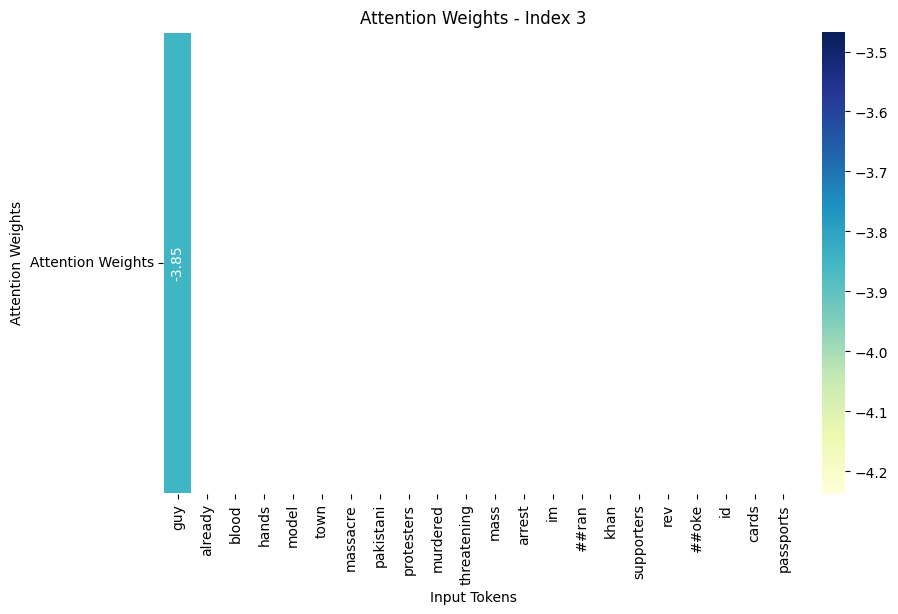

Attention Weights - Index 4:
[3.6373844]


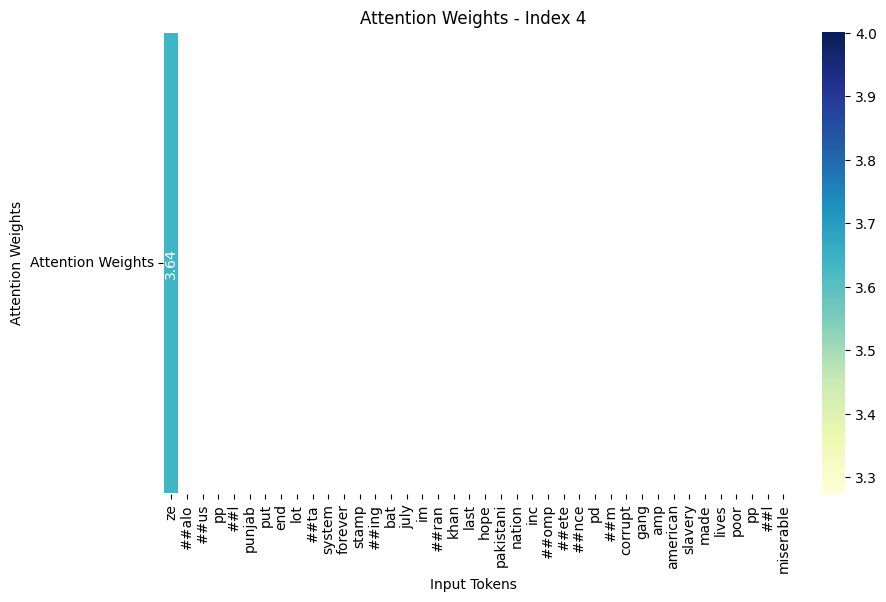

Attention Weights - Index 5:
[3.4402518]


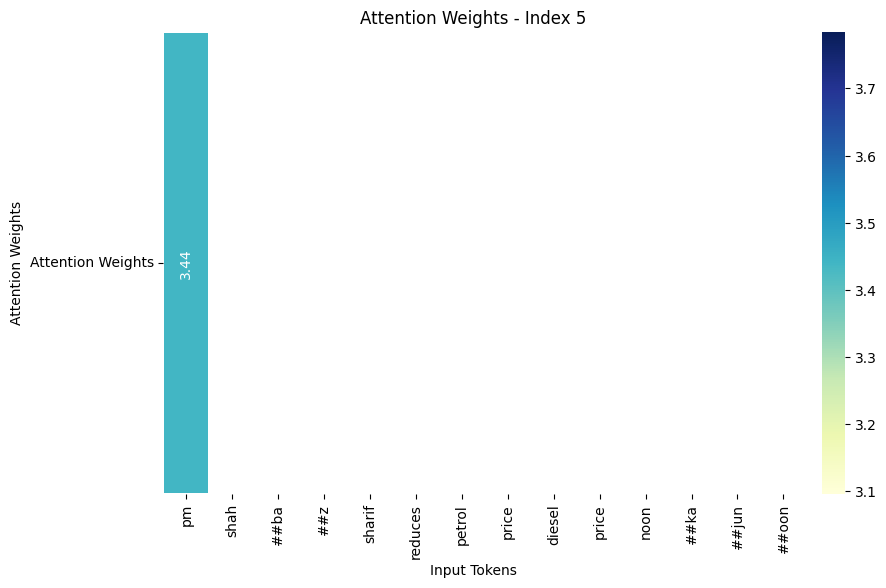

Attention Weights - Index 6:
[-3.7105567]


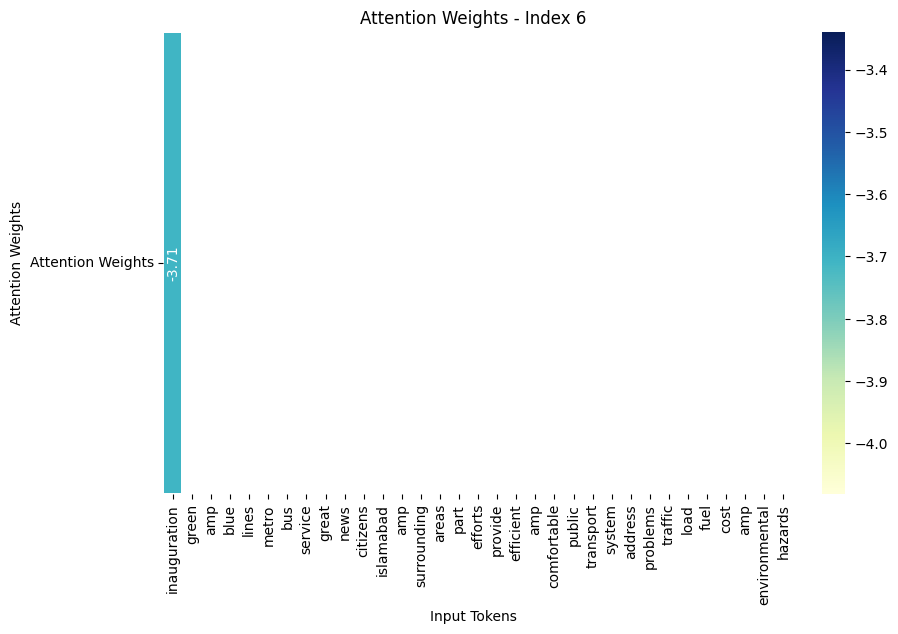

Attention Weights - Index 7:
[3.6368775]


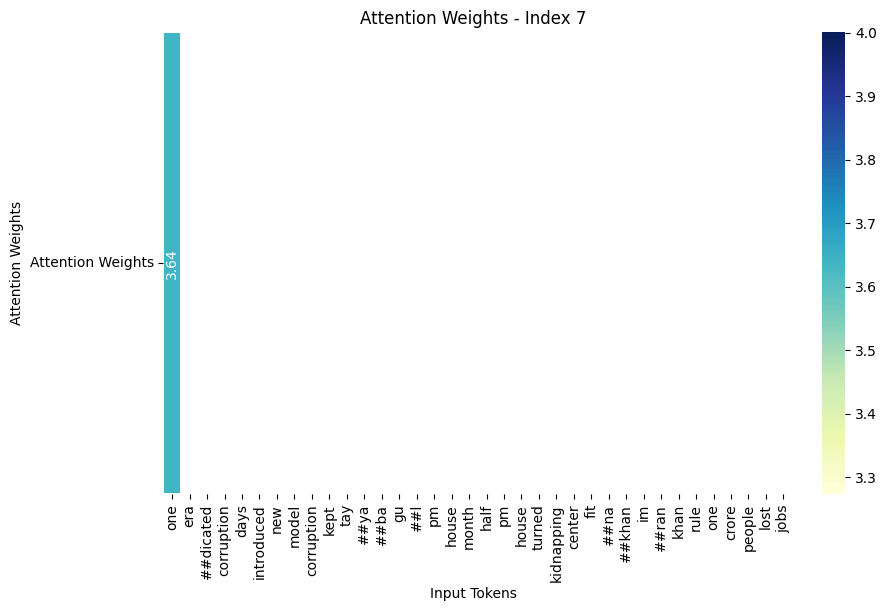

Attention Weights - Index 8:
[3.6424928]


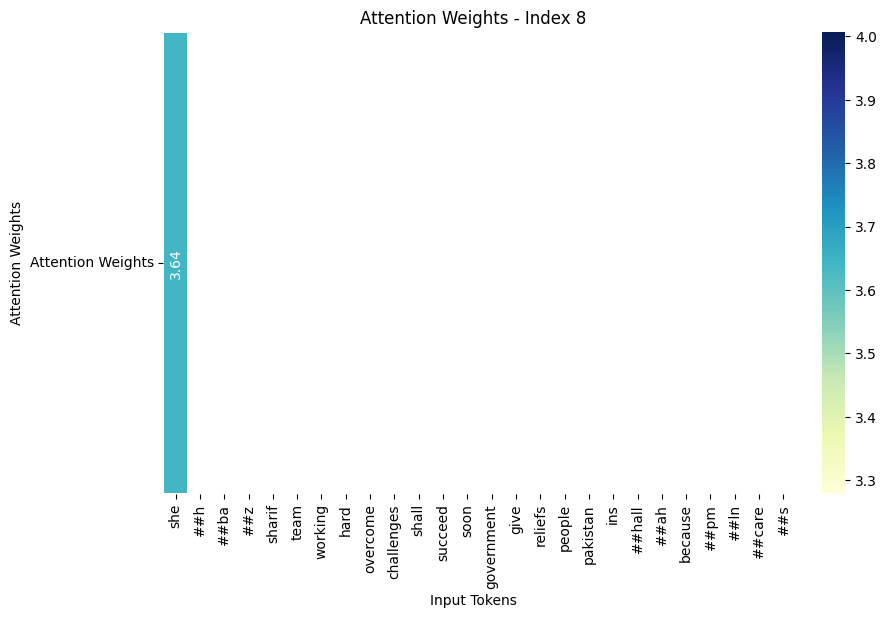

Attention Weights - Index 10:
[2.0468516]


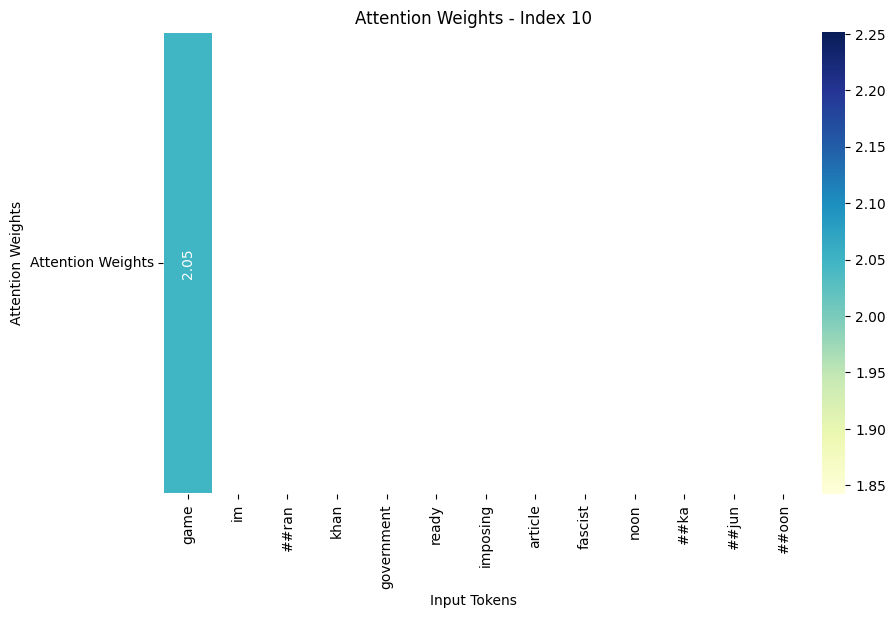

Attention Weights - Index 11:
[3.6508503]


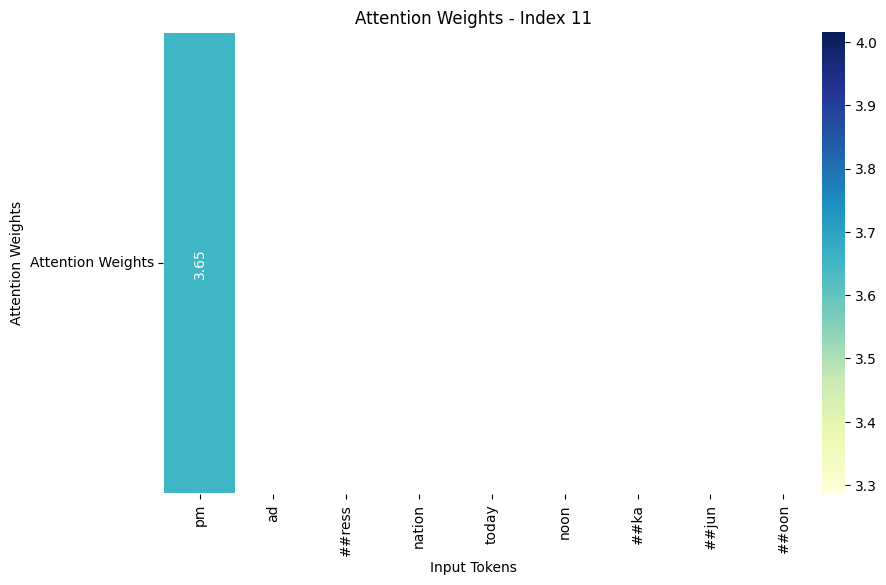

Attention Weights - Index 12:
[-3.4270394]


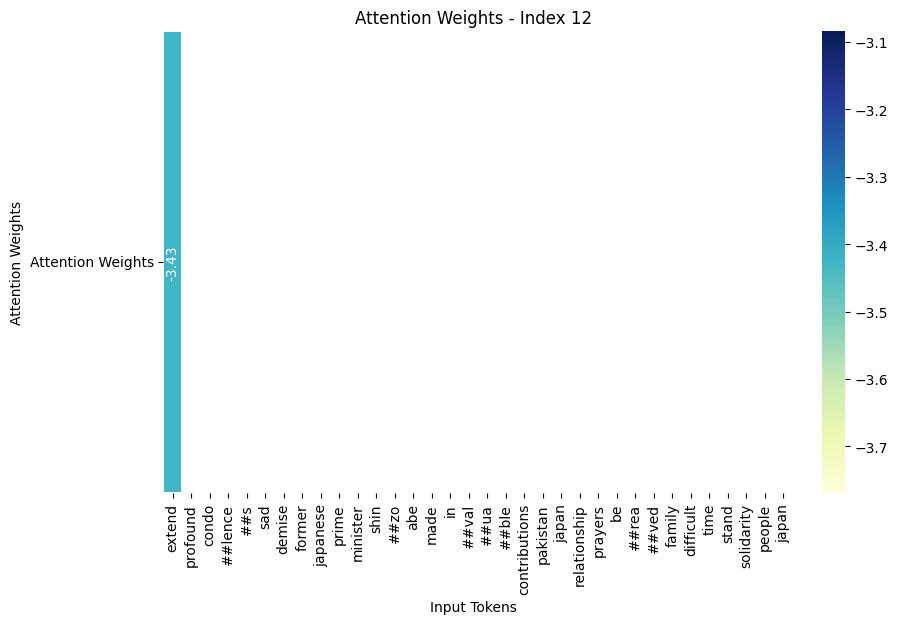

Attention Weights - Index 13:
[3.646671]


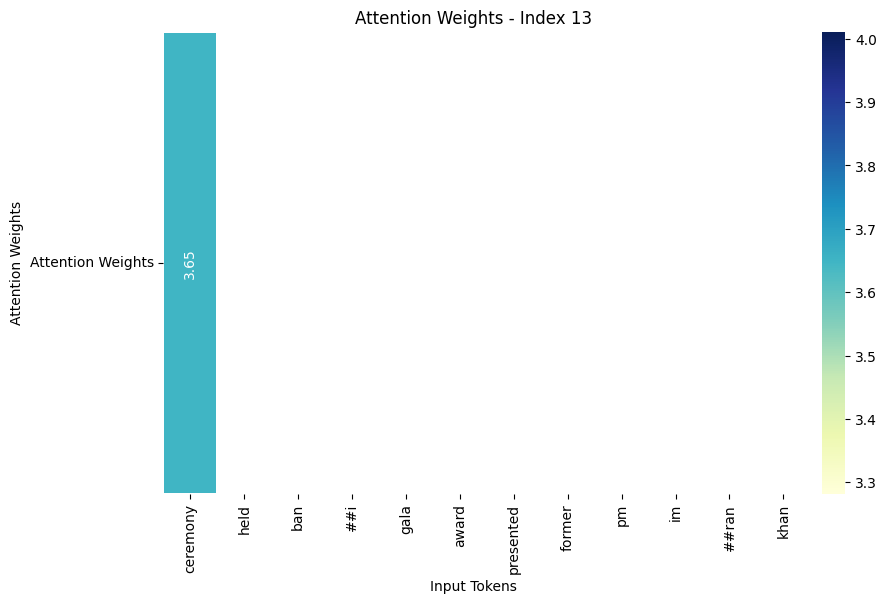

Attention Weights - Index 14:
[-3.7522976]


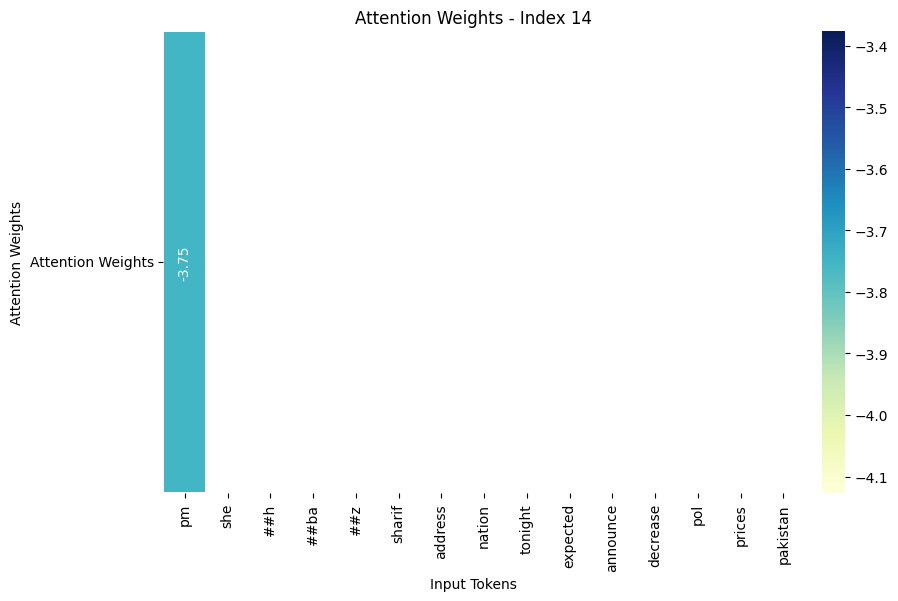

Attention Weights - Index 15:
[3.5705]


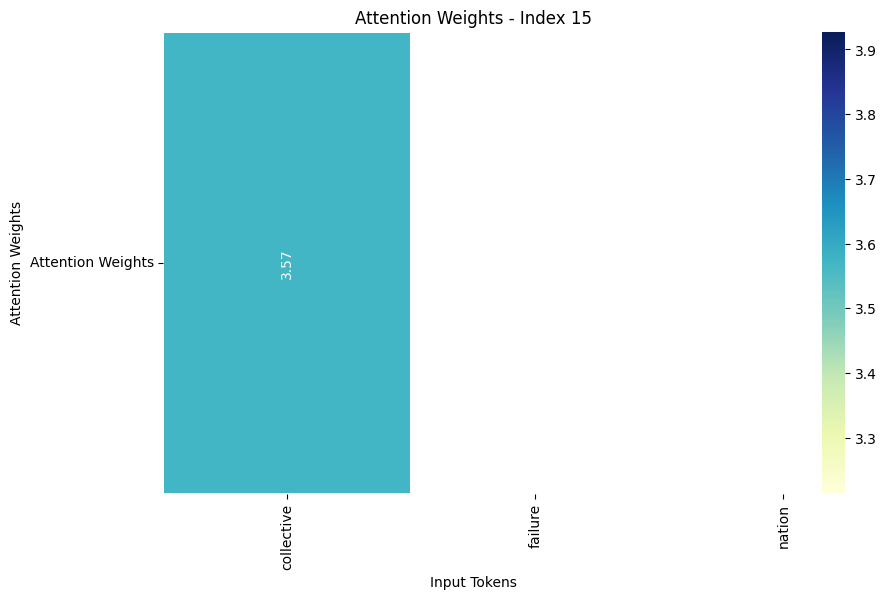

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer

def visualize_attention_weights(model, tokenizer, dataset):
    count = 0
    for index, row in dataset.iterrows():
        # Get the input text from the dataset at the current index
        input_text = row['text']

        # Skip if the input text is empty
        if not input_text:
            continue

        # Tokenize the input text
        input_ids = tokenizer.encode(input_text, add_special_tokens=True, truncation=True, max_length=5012)

        # Convert the input to a PyTorch tensor
        input_tensor = torch.tensor([input_ids]).to(device)

        # Get the attention weights from the model
        model.eval()
        with torch.no_grad():
            outputs = model(input_tensor)
            attention_weights = outputs[-1]  # Get the attention weights from the last layer

        # Reshape and average the attention weights
        attention_weights = attention_weights.squeeze(0)

        # Convert the attention weights to a NumPy array
        attention_weights = attention_weights.cpu().numpy()

        # Remove special tokens from attention weights and input tokens
        attention_weights = attention_weights[1:len(input_ids) - 1]
        input_ids = input_ids[1:len(input_ids) - 1]

        # Print the attention weights
        print(f'Attention Weights - Index {index}:')
        print(attention_weights)

        # Plot the attention weights with values
        plt.figure(figsize=(10, 6))
        sns.heatmap([attention_weights], cmap='YlGnBu', annot=True, fmt='.2f',
                    xticklabels=tokenizer.convert_ids_to_tokens(input_ids),
                    yticklabels=['Attention Weights'], linewidths=0.2,
                    annot_kws={"rotation": "vertical", "verticalalignment": "center"})  # Set vertical alignment
        plt.title(f'Attention Weights - Index {index}')
        plt.xlabel('Input Tokens')
        plt.ylabel('Attention Weights')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.show()

        count += 1
        if count >= 15:
            break

# Example usage
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
visualize_attention_weights(model, tokenizer, df)